# B. Apply Similarity Model to Determine "nice" and "not so nice" Examples

In [1]:
%%capture
pip install -U sentence-transformers

In [2]:
from pathlib import Path
import numpy as np
from numpy.linalg import norm
import pandas as pd

from sentence_transformers import SentenceTransformer

from framework.utils import eda_utils 

/Users/kabu/Documents/workspace/rasa2/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CARBON_BOT = Path('../../../../carbon-bot-e2e')

## Compute Similarities
---

In [4]:
nlu_examples = eda_utils.load_nlu_data(CARBON_BOT /"data" / "nlu.yml")
gold_examples = eda_utils.load_nlu_data("./gold-samples.yml")

/Users/kabu/Documents/workspace/rasa2/rasa/shared/utils/io.py:98: UserWarning: Training data file /Users/kabu/Documents/workspace/carbon-bot-e2e/data/nlu.yml has a lower format version than your Rasa Open Source installation: 2.0 < 3.1. Rasa Open Source will read the file as a version 3.1 file. Please update your version key to 3.1. See https://rasa.com/docs/rasa/training-data-format.
/Users/kabu/Documents/workspace/rasa2/rasa/shared/utils/io.py:98: UserWarning: Training data file /Users/kabu/Documents/workspace/empirical-analysis/workspace/other/carbon-bot_nice-vs-other/gold-samples.yml has a lower format version than your Rasa Open Source installation: 2.0 < 3.1. Rasa Open Source will read the file as a version 3.1 file. Please update your version key to 3.1. See https://rasa.com/docs/rasa/training-data-format.


In [5]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#### Precompute all embeddings

In [6]:
%%time
col_sentence_embedding = "sentence_embedding"
for df in [nlu_examples, gold_examples]:
    df[col_sentence_embedding] = df['text'].apply(lambda text : model.encode([text])[0])
    df = df.drop(columns=['entities'])

CPU times: user 29.1 s, sys: 1.5 s, total: 30.6 s
Wall time: 30.3 s


#### Just iterate, because lazy :)

In [7]:
import numpy as np
from numpy.linalg import norm

In [8]:
%%time
cos_sim = np.zeros(shape=(len(nlu_examples), len(gold_examples)))
for idx_nlu in range(len(nlu_examples)):
    for idx_gold in range(len(gold_examples)):
        a = nlu_examples.iloc[idx_nlu][col_sentence_embedding]
        b = gold_examples.iloc[idx_gold][col_sentence_embedding]
        cos_sim[idx_nlu, idx_gold] = np.dot(a, b)/(norm(a)*norm(b))

CPU times: user 1min 9s, sys: 613 ms, total: 1min 9s
Wall time: 1min 10s


#### Extend Data with Max. Similarity Info 

In [9]:
nlu_examples["argmax-gold-example"] = np.argmax(cos_sim, axis=1)
nlu_examples["max-similarity"] = np.max(cos_sim, axis=1)
nlu_examples["argmax-intent"] = nlu_examples["argmax-gold-example"].apply(lambda gold_idx: gold_examples.iloc[gold_idx]['intent'])

In [10]:
nlu_examples[['text', 'intent', 'argmax-intent', 'max-similarity']]

,text,intent,argmax-intent,max-similarity
0,**YES**,affirm,affirm,0.549619
1,*YES*,affirm,affirm,0.646484
2,"As I've said, yes.",affirm,affirm,0.434290
3,I think so,affirm,affirm,1.000000
4,I think yes,affirm,affirm,0.869060
...,...,...,...,...
2512,whats'your name,faq,greet,0.431908
2513,what's your age?,faq,estimate_emissions,0.369015
2514,who are you,faq,express_positive-emo,0.478335
2515,Carbon offsets will not affect climate !,faq,inquire-ask_clarification-offsets,0.653187


## Cluster: "nice" or "not so nice"?
----

### Approach 1: Threshold

In [11]:
thresholds = pd.DataFrame({"threshold" : np.arange(0.1, 1.05, 0.05)})
thresholds['nice-examples'] = thresholds["threshold"].apply(lambda t : (cos_sim.max(axis=1) >= t).sum())
thresholds['percentage-of-nice-examples'] = thresholds['nice-examples'].apply(lambda x : f"{x/cos_sim.shape[0]:.2%}")

In [12]:
thresholds

,threshold,nice-examples,percentage-of-nice-examples
0,0.10,2517,100.00%
1,0.15,2517,100.00%
2,0.20,2514,99.88%
3,0.25,2495,99.13%
4,0.30,2407,95.63%
5,0.35,2216,88.04%
6,0.40,1963,77.99%
7,0.45,1665,66.15%
8,0.50,1387,55.11%
9,0.55,1134,45.05%


#### Conclusion:
-  if we just go with very high similarity, we only cover a small percentage of examples
- instead let's just the clustering to confirm/deny labels...
- if they "agree", we say it is a "nice" example

### Approach 2: Check Alignment with "Argmax-Intent"

In [13]:
nlu_examples['disagree'] = nlu_examples['argmax-intent'] != nlu_examples['intent']

In [14]:
nlu_examples['disagree'].value_counts()

False    1419
True     1098
Name: disagree, dtype: int64

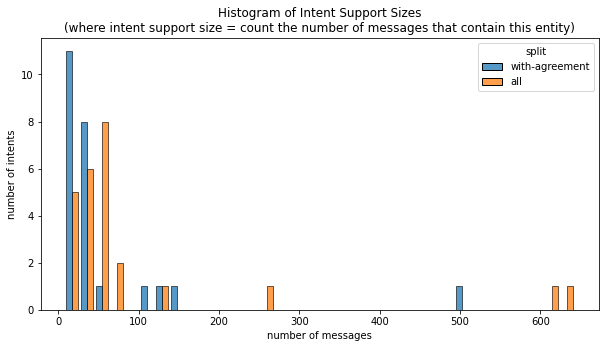

In [15]:
intent_support = eda_utils.intent_support(
    {'with-agreement' : nlu_examples[~nlu_examples['disagree']],
     "all" : nlu_examples,
})

In [16]:
intent_support.sort_values("all", ascending=False)

,intent,with-agreement,all
10,faq,150,643
15,inform,495,616
1,affirm,129,255
18,inquire-ask_clarification-offsets,102,124
5,estimate_emissions,21,73
3,deny,38,69
12,greet,52,63
19,insult,35,63
24,why,34,59
16,inform_notunderstanding,26,58


##  Save the Result
----

In [17]:
import rasa.shared.utils.io as rasa_io_utils
from rasa.shared.nlu.training_data.message import Message
from rasa.shared.nlu.training_data.training_data import TrainingData
from rasa.shared.nlu.constants import TEXT, ENTITIES, INTENT

In [18]:
def write_to_yml(df : pd.DataFrame, intent_col :str, out_path : str) -> None:
    td = TrainingData(
        training_examples=[
            Message(data={TEXT: str(text), INTENT: intent})
            for text, intent in zip(df[TEXT], df[intent_col])
        ]
    )
    rasa_io_utils.write_text_file(td.nlu_as_yaml(), out_path)

In [19]:
write_to_yml( df = nlu_examples[nlu_examples['disagree']], intent_col = 'intent', out_path = './noisy.yml')
write_to_yml( df = nlu_examples[~nlu_examples['disagree']], intent_col = 'intent', out_path = './clean.yml')